In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml

from utils import reflect_points_to_left


In [2]:
predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/2024-11-04/16-15-17/test_brain_predictions.npy" # 64 cells
ccf_files_path = "/grid/zador/data_norepl/Ari/transcriptomics/CCF_files"

predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/single_cell_preds_32/validation_brain_predictions.npy" # 128 cells

In [3]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

## Single cells

In [7]:
# First, create the master color mapping (before any loops)
def create_master_colormap(folds_range, group_size, val_or_test):
    all_categories = set()
    label_names = None
    for f in folds_range:
        predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/fold{f}_all_exhausted_{group_size}/{val_or_test}_brain_predictions.npy"
        pred_dict = np.load(predictions_path, allow_pickle=True).item()
        all_categories.update(np.unique(pred_dict['single_cell_labels']))
        all_categories.update(np.unique(pred_dict['single_cell_predictions']))
        if label_names is None and 'label_names' in pred_dict:
            label_names = pred_dict['label_names']
    
    # Convert to sorted list for consistent ordering
    all_categories = sorted(list(all_categories))
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])
    
    # Map categories to colors
    color_indices = np.arange(len(all_categories)) % len(colors)
    color_map = dict(zip(all_categories, colors[color_indices]))
    
    return color_map, label_names

def plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat):
    """Plot the scatter-style visualization with three panels"""
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Panel 1: Labels
    colors_labels = np.array([color_map[label] for label in labels])
    ax[0].scatter(x, y, color=colors_labels, alpha=.5, linewidths=0, s=5)
    ax[0].set_title("Area labels")
    
    # Panel 2: Predictions
    colors_preds = np.array([color_map[pred] for pred in preds])
    ax[1].scatter(x, y, color=colors_preds, alpha=.5, linewidths=0, s=5)
    ax[1].set_title("Area predictions")
    
    # Panel 3: Errors
    misclassified = labels != preds
    ax[2].scatter(x[misclassified], y[misclassified], color='r', alpha=.5, linewidths=0, s=5)
    ax[2].set_title("Errors")
    
    # Common styling for all panels
    for a in ax:
        a.grid(False)
        for k, boundary_coords in bf_left_boundaries_flat.items():
            a.plot(*boundary_coords.T, c="k", lw=0.5)
        a.axis('off')
        a.set_aspect('equal')
        a.set_ylim(a.get_ylim()[::-1])
    
    plt.tight_layout()
    return f, ax

import matplotlib as mpl

def create_hexbin_categorical(x, y, labels, label_map=None, gridsize=30):
    """
    Create a hexagonal binning plot for categorical data.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates of the points
    y : array-like
        y-coordinates of the points
    labels : array-like
        categorical labels for each point
    label_map : dict, optional
        mapping from numerical IDs to string labels for legend
    gridsize : int, optional
        number of hexagons in the x-direction
    
    Returns:
    --------
    fig : matplotlib figure
    ax : matplotlib axes
    hexbin_data : pandas DataFrame
    """
    # Convert data to DataFrame
    df = pd.DataFrame({
        'x': x,
        'y': y,
        'label': labels
    })
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate data extent
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    # Create a temporary hexbin to get the hex locations and sizes
    hb = ax.hexbin(x, y, gridsize=gridsize, extent=(xmin, xmax, ymin, ymax), visible=False)
    
    # Get hex centers and corners
    hex_centers = hb.get_offsets()
    hex_path = hb.get_paths()[0]
    
    # Function to find modal category
    def get_modal_category(points):
        if len(points) == 0:
            return np.nan
        values, counts = np.unique(points, return_counts=True)
        if len(counts) == 0:
            return np.nan
        return values[np.argmax(counts)]
    
    hex_stats = []
    for i, center in enumerate(hex_centers):
        # Transform the generic hex path to this specific hexagon's position
        vertices = hex_path.vertices + center
        
        # Find points within this hexagon
        mask = mpl.path.Path(vertices).contains_points(df[['x', 'y']])
        if mask.any():
            points_in_hex = df[mask]
            modal_cat = get_modal_category(points_in_hex['label'])
            hex_stats.append({
                'hex_id': i,
                'modal_category': modal_cat,
                'count': len(points_in_hex),
                'center_x': center[0],
                'center_y': center[1]
            })
    
    hex_stats = pd.DataFrame(hex_stats)
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])

    # Get unique categories and map to extended colors
    unique_categories = np.unique(labels[~pd.isna(labels)])
    n_categories = len(unique_categories)
    color_indices = np.arange(n_categories) % len(colors)
    category_colors = dict(zip(unique_categories, colors[color_indices]))
    
    # Create collection of hexagons
    patches = []
    colors = []
    for _, row in hex_stats.iterrows():
        center = (row['center_x'], row['center_y'])
        vertices = hex_path.vertices + center
        patch = mpl.patches.Polygon(vertices)
        patches.append(patch)
        colors.append(category_colors[row['modal_category']])
    
    # Plot hexagons
    collection = mpl.collections.PatchCollection(
        patches, 
        facecolors=colors,
        edgecolors='white',
        linewidth=0.5,
        alpha=0.7
    )
    ax.add_collection(collection)
    
    # Set plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Add legend with mapped labels
    legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7)
                      for color in category_colors.values()]
    
    if label_map is not None:
        legend_labels = [label_map.get(int(cat), str(cat)) for cat in category_colors.keys()]
    else:
        legend_labels = [str(cat) for cat in category_colors.keys()]
    
    ax.legend(legend_elements, legend_labels,
             title='Categories', loc='center left', bbox_to_anchor=(1, 0.5))
        
    # Set equal aspect ratio
    ax.set_aspect('equal')

    ax.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        ax.plot(*boundary_coords.T, c="k", lw=0.5)

    ax.axis('off')
    # reverse y-axis
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Adjust layout to prevent legend overlap
    plt.tight_layout()


    
    return fig, ax, hex_stats

def plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names, gridsize=50):
    """Plot the hexbin-style visualization"""
    fig, ax, hex_stats = create_hexbin_categorical(
        x, y, preds,
        label_map={int(k): v for k, v in label_names.items()} if label_names else None,
        gridsize=gridsize
    )
    return fig, ax, hex_stats

# Main execution loop
    # Create master colormap
   


/tmp/ipykernel_1746810/3065053901.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


Fold 0
Accuracy 77.95


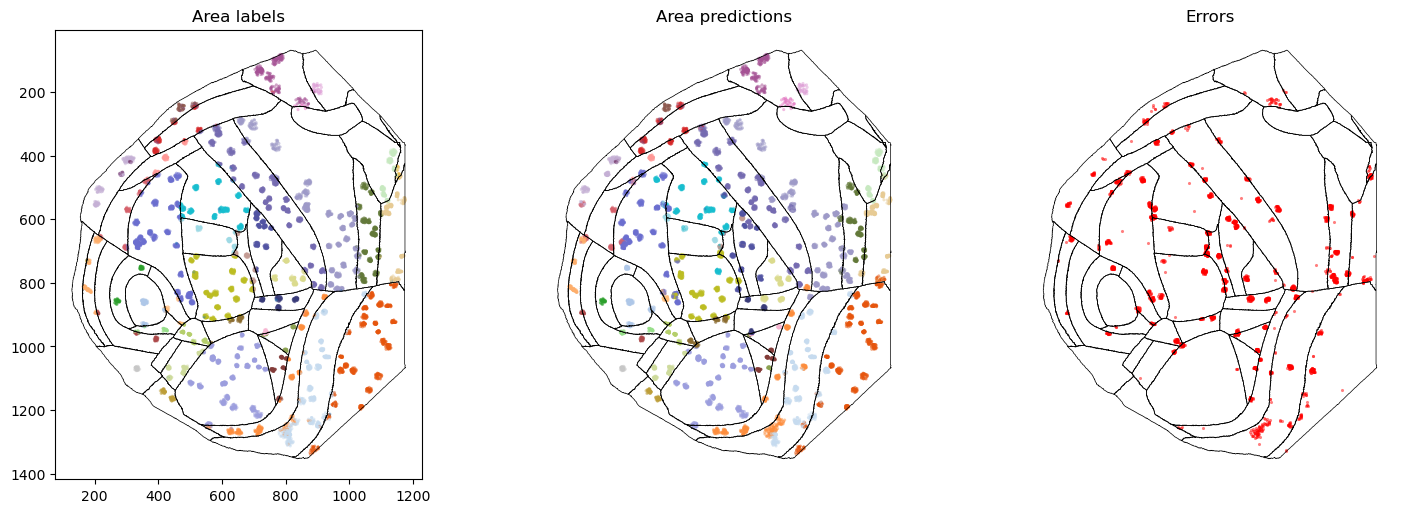

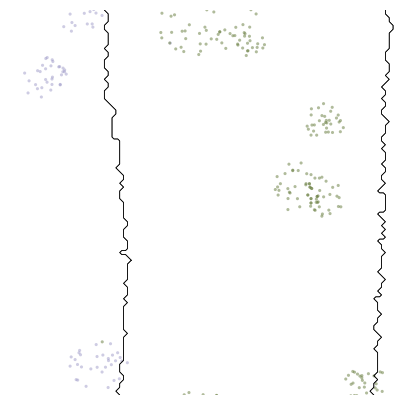

In [14]:
folds_range = range(4)
group_size = 32
val_or_test = 'validation'

color_map, label_names = create_master_colormap(folds_range, group_size, val_or_test)
    
for f in [0]:
    print("Fold", f)
    # Load data
    predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/fold{f}_all_exhausted_{group_size}/{val_or_test}_brain_predictions.npy"
    pred_dict = np.load(predictions_path, allow_pickle=True).item()
    dataset = load_from_disk(f"/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/train_test_barseq_all_exhausted_fold{f}.dataset")

    # Prepare data
    every = 10000
    labels = np.array(pred_dict['single_cell_labels']).flatten()[:every]
    preds = np.array(pred_dict['single_cell_predictions']).flatten()[:every]
    indices = np.array(pred_dict['indices']).flatten()[:every]

    xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
    xyz = reflect_points_to_left(xyz)
    x, y = xyz[:,0], xyz[:,1]

    # Calculate accuracy
    acc = (preds == labels).sum() / len(labels)
    print("Accuracy", 100*acc)

    # Plot based on style
    fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat)
    ax[0].set_axis_on()
    plt.savefig(f'fig2b_sparse_flatmap.png', dpi=300)
    plt.show()

    plt.figure(figsize=(5,5))
    colors_labels = np.array([color_map[label] for label in labels])
    plt.scatter(x, y, color=colors_labels, alpha=.5, linewidths=0, s=5)
    plt.xlim(1000, 1100)
    plt.ylim(600, 700)
    a = plt.gca()
    a.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)
    a.axis('off')
    a.set_aspect('equal')
    a.set_ylim(a.get_ylim()[::-1])
    plt.savefig(f'fig2b_sparse_flatmap_zoom.png', dpi=300)
    # fig, ax, _ = plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names)
    # plt.savefig(f'fold{f}_all_exhausted-preds-{val_or_test}-{group_size}-hex.png', dpi=300)
    # plt.show()

    # Save figure
    

/tmp/ipykernel_4153955/3065053901.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


Fold 0
Accuracy 79.9022651999


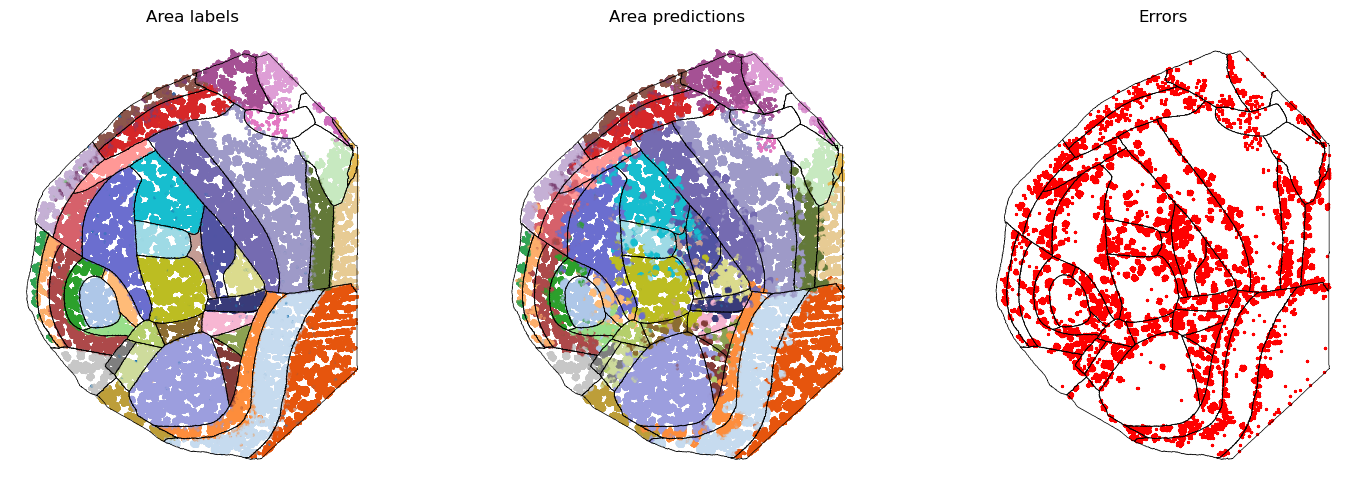

/tmp/ipykernel_4153955/3065053901.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


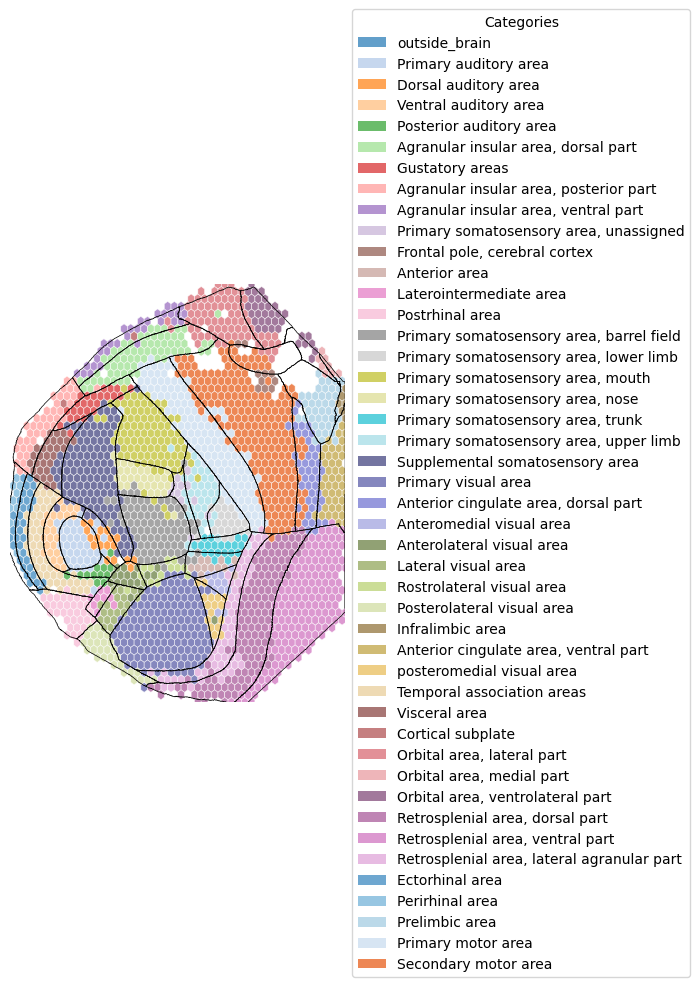

Fold 1
Accuracy 77.0101431275


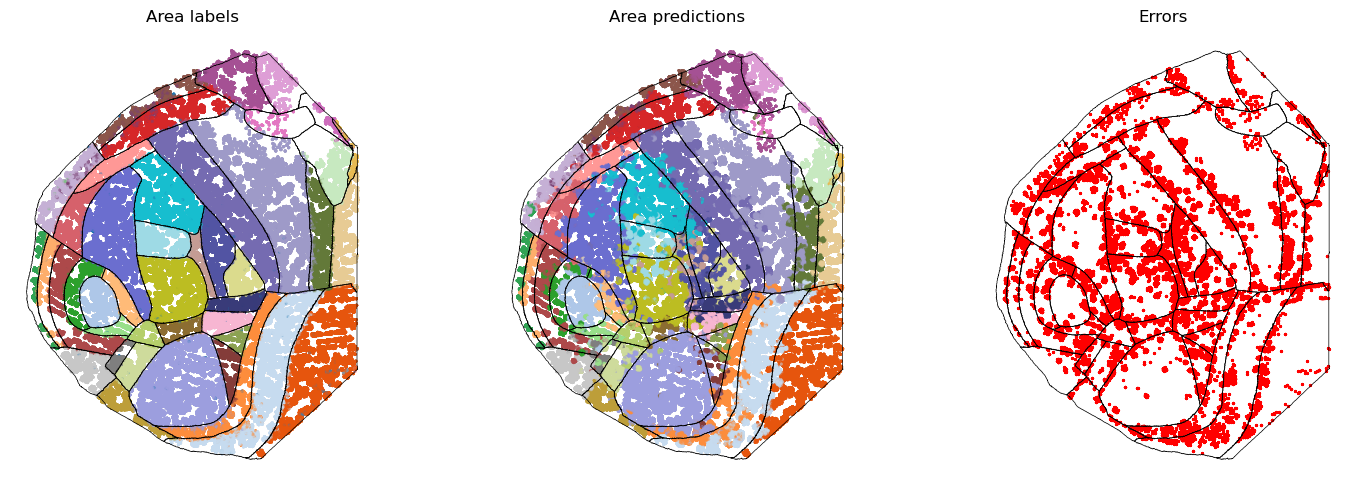

/tmp/ipykernel_4153955/3065053901.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


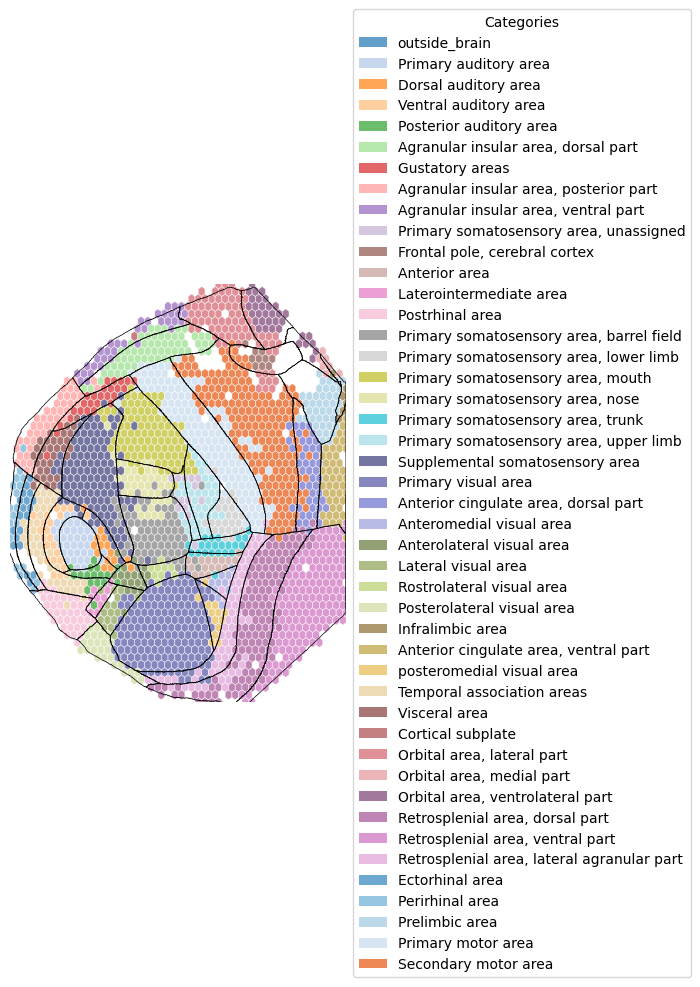

Fold 2
Accuracy 78.0444909955


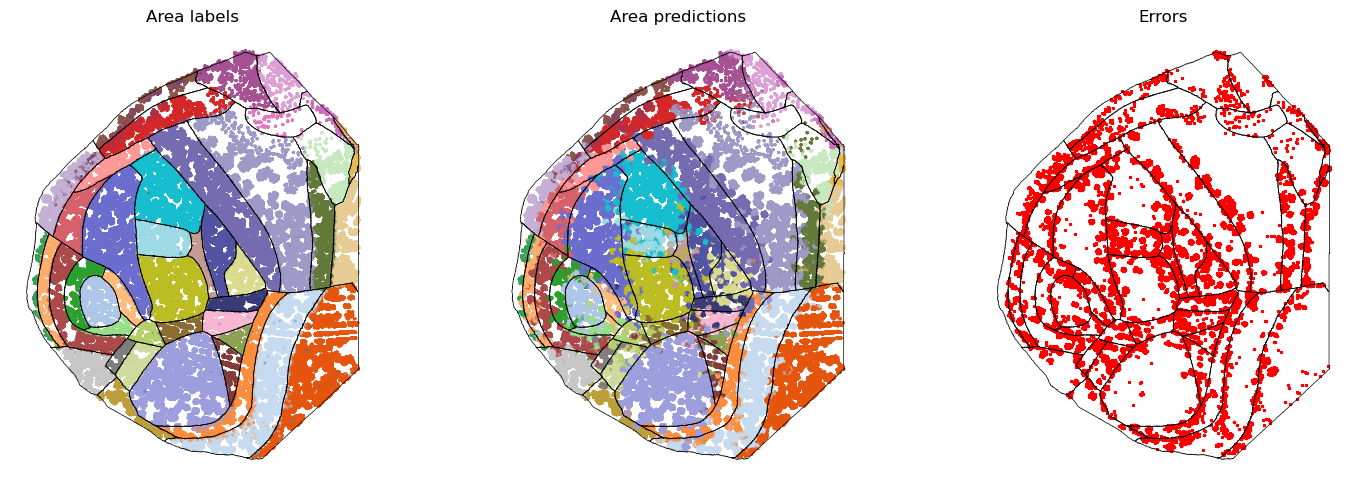

/tmp/ipykernel_4153955/3065053901.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


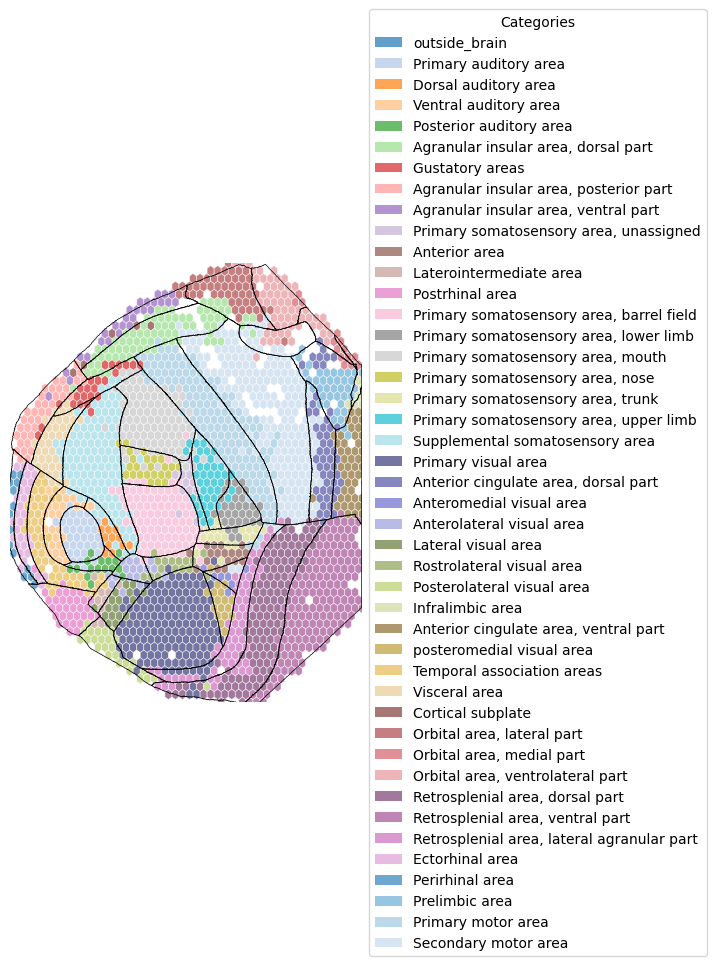

Fold 3
Accuracy 77.7132126804


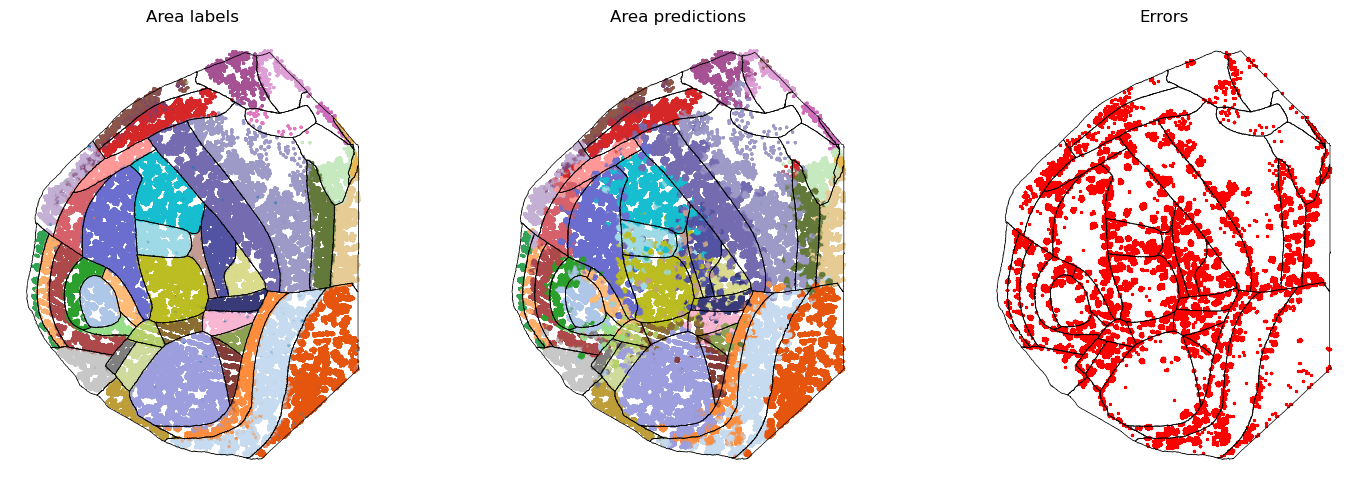

/tmp/ipykernel_4153955/3065053901.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


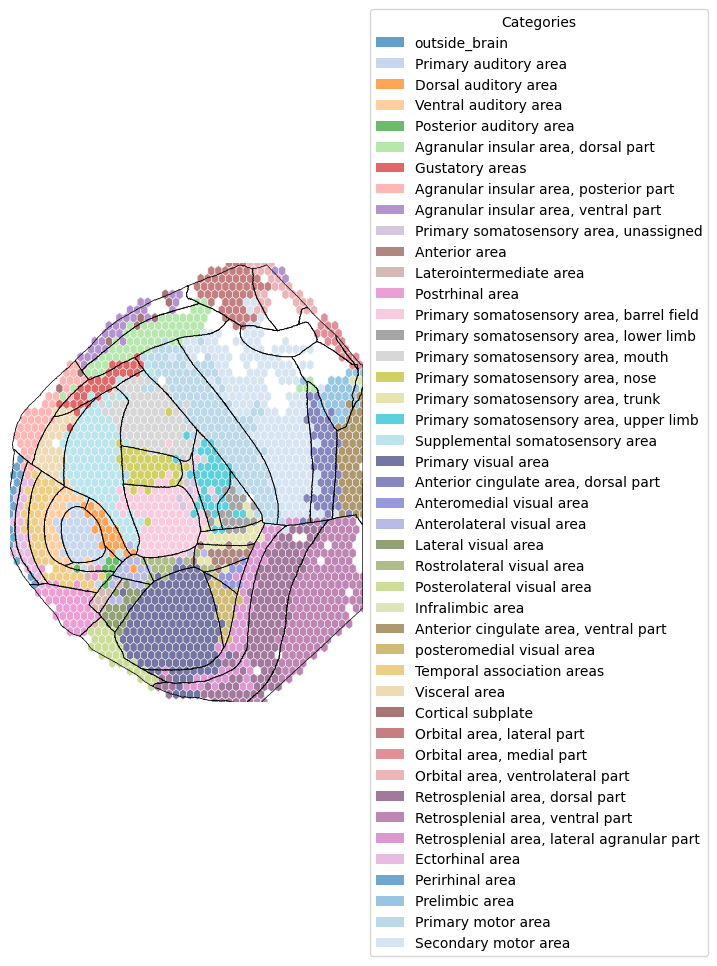

In [14]:
folds_range = range(4)
group_size = 32
val_or_test = 'validation'

color_map, label_names = create_master_colormap(folds_range, group_size, val_or_test)
    
for f in folds_range:
    print("Fold", f)
    # Load data
    predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/fold{f}_all_exhausted_{group_size}/{val_or_test}_brain_predictions.npy"
    pred_dict = np.load(predictions_path, allow_pickle=True).item()
    dataset = load_from_disk(f"/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/train_test_barseq_all_exhausted_fold{f}.dataset")

    # Prepare data
    every = 1
    labels = np.array(pred_dict['single_cell_labels']).flatten()[::every]
    preds = np.array(pred_dict['single_cell_predictions']).flatten()[::every]
    indices = np.array(pred_dict['indices']).flatten()[::every]

    xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
    xyz = reflect_points_to_left(xyz)
    x, y = xyz[:,0], xyz[:,1]

    # Calculate accuracy
    acc = (preds == labels).sum() / len(labels)
    print("Accuracy", 100*acc)

    # Plot based on style
    fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat)
    plt.savefig(f'fold{f}_all_exhausted-preds-{val_or_test}-{group_size}.png', dpi=300)
    plt.show()
    fig, ax, _ = plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names)
    plt.savefig(f'fold{f}_all_exhausted-preds-{val_or_test}-{group_size}-hex.png', dpi=300)
    plt.show()

    # Save figure
    

Accuracy 74.7810448297


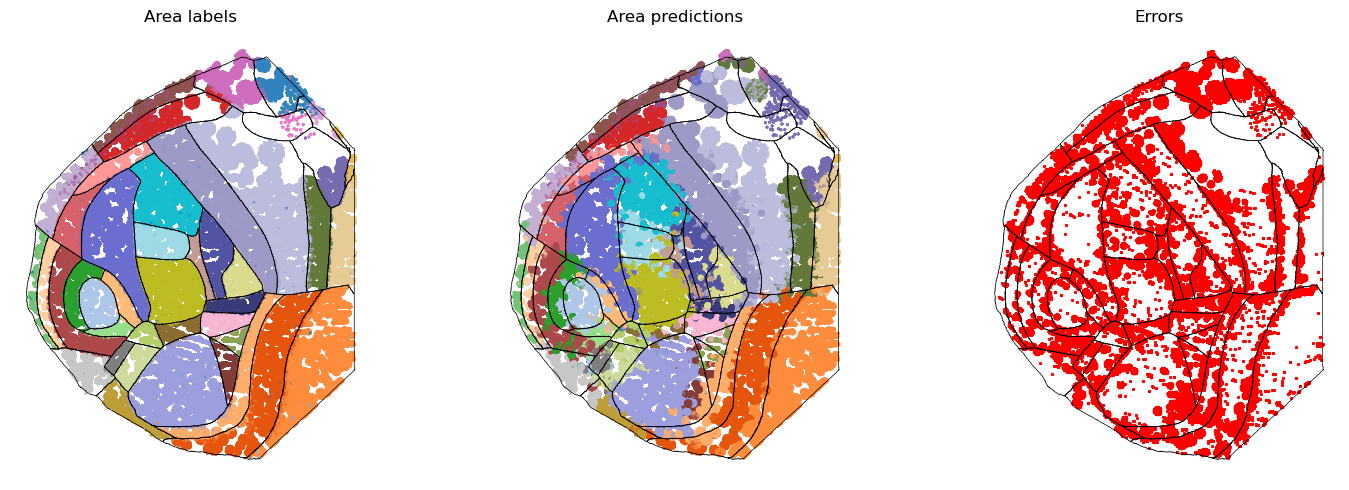

/tmp/9974156.1.comp.q/ipykernel_1458727/1638163640.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


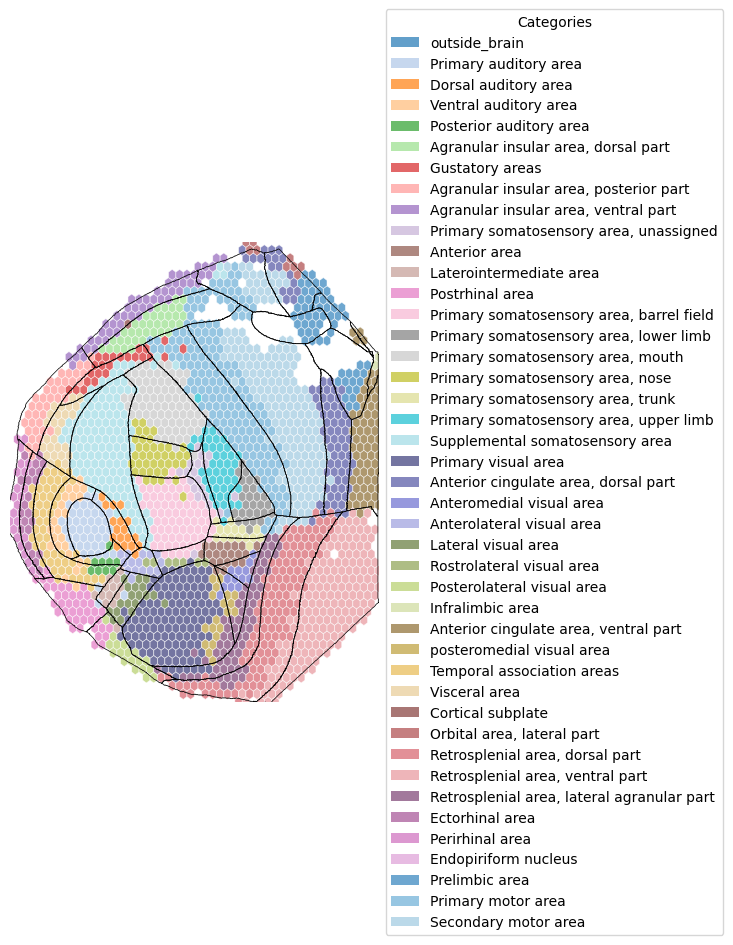

In [11]:
group_size=256

# Load data
predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/test_enucleated_balancedBatchSize_{group_size}/{val_or_test}_brain_predictions.npy"
pred_dict = np.load(predictions_path, allow_pickle=True).item()
dataset = load_from_disk(f"/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/train_test_barseq_raw_counts_test_enucleated.dataset")

# Prepare data
every = 1
labels = np.array(pred_dict['single_cell_labels']).flatten()[::every]
preds = np.array(pred_dict['single_cell_predictions']).flatten()[::every]
indices = np.array(pred_dict['indices']).flatten()[::every]

xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
xyz = reflect_points_to_left(xyz)
x, y = xyz[:,0], xyz[:,1]

# Calculate accuracy
acc = (preds == labels).sum() / len(labels)
print("Accuracy", 100*acc)

# Plot based on style
fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat)
plt.savefig(f'test_enucleated_single-cell-preds-{val_or_test}-{group_size}.png', dpi=300)
plt.show()
fig, ax, _ = plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names)
plt.savefig(f'test_enucleated_single-cell-preds-{val_or_test}-{group_size}-hex.png', dpi=300)
plt.show()


In [ ]:
### Preds

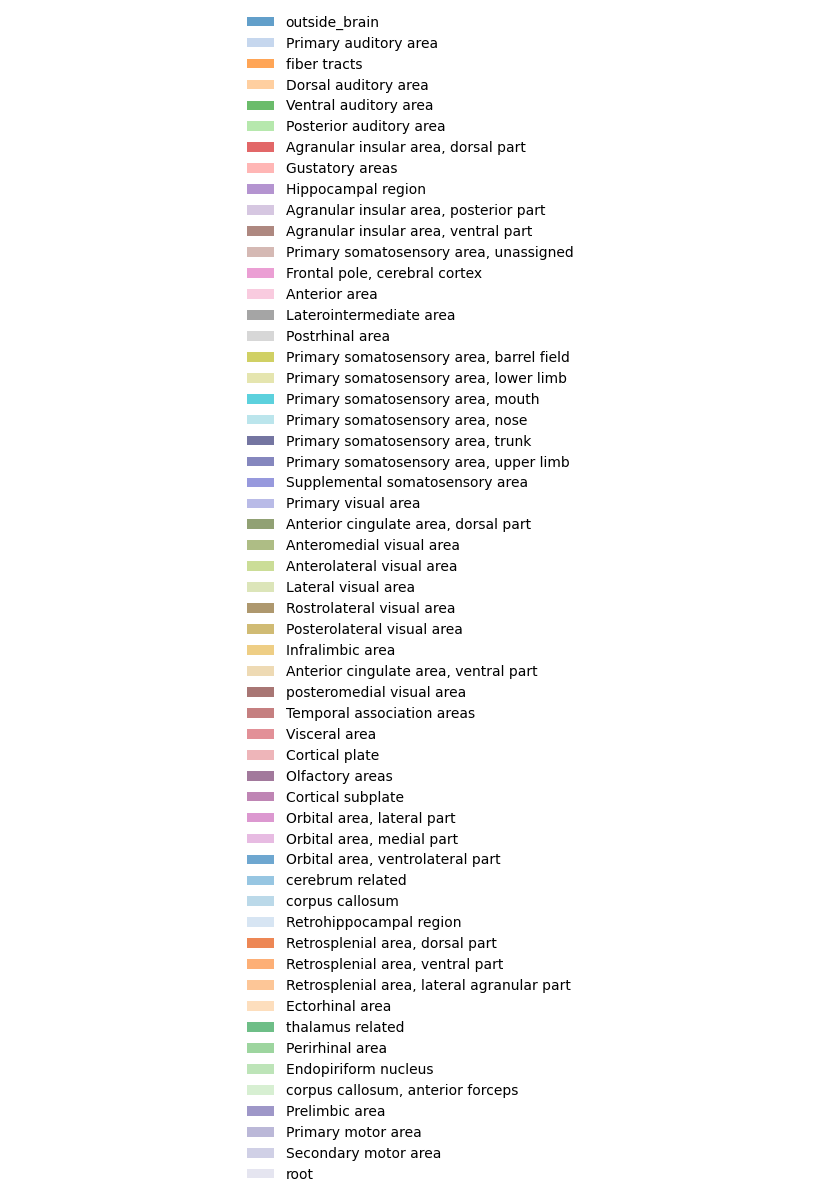

In [8]:
def create_standalone_legend(color_map, label_names=None, figsize=(8, 10)):
    """
    Create a standalone legend figure from a color map and optional label names.
    
    Parameters:
    -----------
    color_map : dict
        Dictionary mapping categories to colors
    label_names : dict, optional
        Dictionary mapping numerical IDs to string labels
    figsize : tuple, optional
        Figure size (width, height)
        
    Returns:
    --------
    fig : matplotlib figure
        The legend figure
    """
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Create legend elements
    legend_elements = []
    legend_labels = []
    
    # Sort categories for consistent ordering
    categories = sorted(color_map.keys())
    
    for cat in categories:
        # Create patch for legend
        patch = plt.Rectangle((0, 0), 1, 1, facecolor=color_map[cat], alpha=0.7)
        legend_elements.append(patch)
        
        # Get label
        if label_names is not None:
            try:
                # Try to convert category to int for label lookup
                label = label_names.get(int(cat), str(cat))
            except (ValueError, TypeError):
                # If conversion fails, use category as is
                label = str(cat)
        else:
            label = str(cat)
            
        legend_labels.append(label)
    
    # Create legend
    ax.legend(legend_elements, legend_labels,
             loc='center',
             bbox_to_anchor=(0.5, 0.5),
             ncol=1,
             fontsize=10,
             frameon=False)
    
    # Hide axes
    ax.set_axis_off()
    
    return fig

# Usage example:
legend_fig = create_standalone_legend(color_map, label_names)
legend_fig.savefig('legend.png', bbox_inches='tight', dpi=300)


In [10]:
!git commit legend.png test_en* -m "test_enucleated"

[benchmarks d341091] test_enucleated
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 figures/legend.png
 create mode 100644 figures/test_enucleated_single-cell-preds-test-32-hex.png
 create mode 100644 figures/test_enucleated_single-cell-preds-test-32.png


##### Split group labels with group size



In [7]:

def check_identical_rows(arr):
    """
    Returns a boolean array indicating which rows have identical elements.
    
    Parameters:
    arr (numpy.ndarray): 2D input array
    
    Returns:
    numpy.ndarray: 1D boolean array, True where row elements are identical
    """
    return np.all(arr == arr[:, [0]], axis=1)

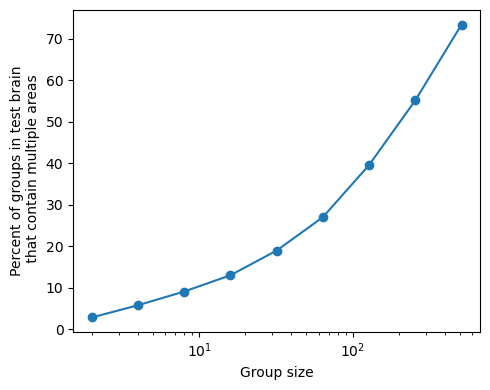

In [22]:
group_sizes = np.exp2(np.arange(1,10))
frac_single_labels = []

for group_size in group_sizes:
    predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/single_cell_preds_hex_groups_{group_size:.0f}/test_brain_predictions.npy" # group_size cells
    pred_dict = np.load(predictions_path, allow_pickle=True).item()

    labels = np.array(pred_dict['single_cell_labels'])

    frac_single_labels.append((1-check_identical_rows(labels).sum() / len(labels))*100)
    
plt.figure(figsize=(5,4))
plt.plot(group_sizes, frac_single_labels, marker='o')

plt.xlabel("Group size")
plt.ylabel("Percent of groups in test brain\n that contain multiple areas")
plt.xscale('log', base=10)
plt.tight_layout()
plt.savefig("num_areas_in_group.png", dpi=300)

